In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim

In [7]:
good_sizes = np.sort(np.array([
    512, 768, 1024, 1280, 2048, 2304, 2560, 3072, 
    3840, 4096, 5120, 6400, 6912, 7680, 8192]))

def _get_good_sizes(sizes):
    ind = np.searchsorted(good_sizes, sizes)
    return good_sizes[ind]

exposure_time = 90  # s
max_wind_speed = 20  # m/s

max_screen_size = (
    exposure_time *
    max_wind_speed)

altitude = [0, 2.58, 5.16, 7.73, 12.89, 15.46]  # km
fov = 2.2  # degrees
max_screen_size = np.maximum(
    max_screen_size * 1.5, # factor of 1.5 for periodic FFTs
    max_screen_size + 2 * np.array(altitude) * 1e3 * 2.2 / 180 * np.pi  # 2 fields of view
)

eff_r0_500 = 0.1  # m
weights = [0.652, 0.172, 0.055, 0.025, 0.074, 0.022]
screen_r0_500 = eff_r0_500 * np.power(weights, -3.0/5.0)
screen_scales = np.clip(0.5 * screen_r0_500, 0.1, np.inf)

# compute a good FFT size, clipping at max of 8192
nominal_npix = np.clip(np.ceil(max_screen_size / screen_scales).astype(int), 0, 8192)
npix = _get_good_sizes(nominal_npix)

# for screens that need too many pixels, 
# we can either go back and make the overall size smaller 
# or make the pixels bigger
# here I am going to make the size smaller since we want the proper power
# but can tolerate some wrapping of the FFTs on average
screen_sizes = screen_scales * npix

print('screen # of pixels', npix)
print('screen pixel sizes:', screen_scales)
print('pixel size / r0_500:', screen_scales / screen_r0_500)
print('fraction of ideal screen size:', screen_sizes/max_screen_size)

screen # of pixels [8192 8192 8192 6400 8192 6400]
screen pixel sizes: [0.1        0.14376492 0.28493932 0.45730505 0.23846847 0.49376056]
pixel size / r0_500: [0.77365717 0.5        0.5        0.5        0.5        0.5       ]
fraction of ideal screen size: [0.30340741 0.43619343 0.86452702 1.08398235 0.70022119 1.05785429]


In [8]:
rng = np.random.RandomState(seed=10)

speed = rng.uniform(0, max_wind_speed, size=6)  # m/s
direction = [rng.uniform(0, 360) * galsim.degrees for i in range(6)]

atm = galsim.Atmosphere(
    r0_500=screen_r0_500,
    screen_size=screen_sizes,
    altitude=altitude,
    L0=25.0,
    speed=speed,
    direction=direction,
    screen_scale=screen_scales,
    rng=galsim.BaseDeviate(rng.randint(0, 2**32-1)))

In [29]:
import tqdm

def _makePSF(x, y, scale, atm, fwhm, exptime):
    psf = atm.makePSF(
        lam=700.0, 
        exptime=exptime, 
        diam=4, 
        obscuration=0.42,
        theta=((x * scale) * galsim.arcsec, (y * scale) * galsim.arcsec))

    if fwhm > 0:
        psf = galsim.Convolve(
            galsim.Gaussian(fwhm=fwhm).shear(eta1=0.4, eta2=0.0), psf)
    psf = galsim.Convolve(optpsf, psf)

    return psf


def _get_fwhm_g1g2(psf_im):
    mom = galsim.hsm.FindAdaptiveMom(psf_im)
    return (
        mom.moments_sigma * psf_im.scale * 2.355, 
        mom.observed_shape.g1, 
        mom.observed_shape.g2,
        psf_im.calculateFWHM())


def _measure_atm(atm, fwhm, exptime):
    n = 20
    s = np.linspace(0, 225, n)
    fwhms = np.zeros((n, n))
    g1 = np.zeros_like(fwhms)
    g2 = np.zeros_like(fwhms)
    for i in tqdm.trange(n):
        sx = s[i]
        for j, sy in enumerate(s):
            psf_im = _makePSF(sx, sy, 0.25, atm, fwhm, exptime).drawImage(
                nx=33, ny=33, scale=0.25, method='phot', n_photons=1e5)
            res = _get_fwhm_g1g2(psf_im)
            fwhms[j, i] = res[0]
            g1[j, i] = res[1]
            g2[j, i] = res[2]
    return fwhms, g1, g2

(1.0030384643375874, 0.045270699818941794, 0.00022311670762563835, 0.931977878620185)
CPU times: user 1.27 s, sys: 270 ms, total: 1.54 s
Wall time: 1.35 s


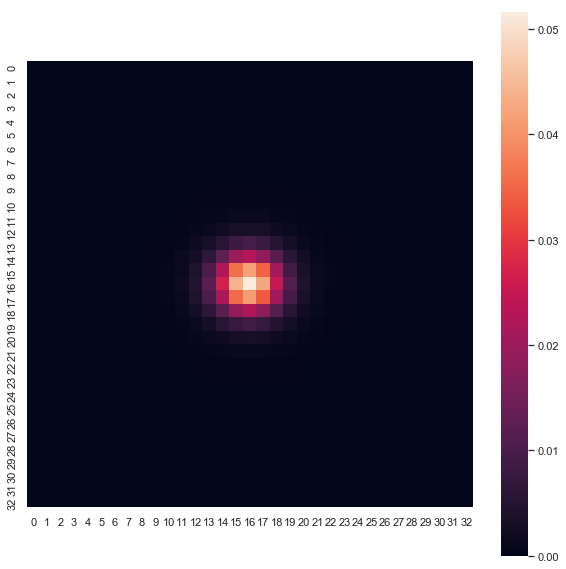

In [16]:
%%time 

psf_im = _makePSF(0, 0, 0.25, atm, 0, 90).drawImage(
    nx=33, ny=33, scale=0.25, method='phot', n_photons=1e6)
print(_get_fwhm_g1g2(psf_im))
plt.figure(figsize=(10, 10))
sns.heatmap(psf_im.array, square=True)

In [ ]:
fwhms, g1, g2 = _measure_atm(atm, 0.0, 15)

Text(0.5, 1.0, 'g2')

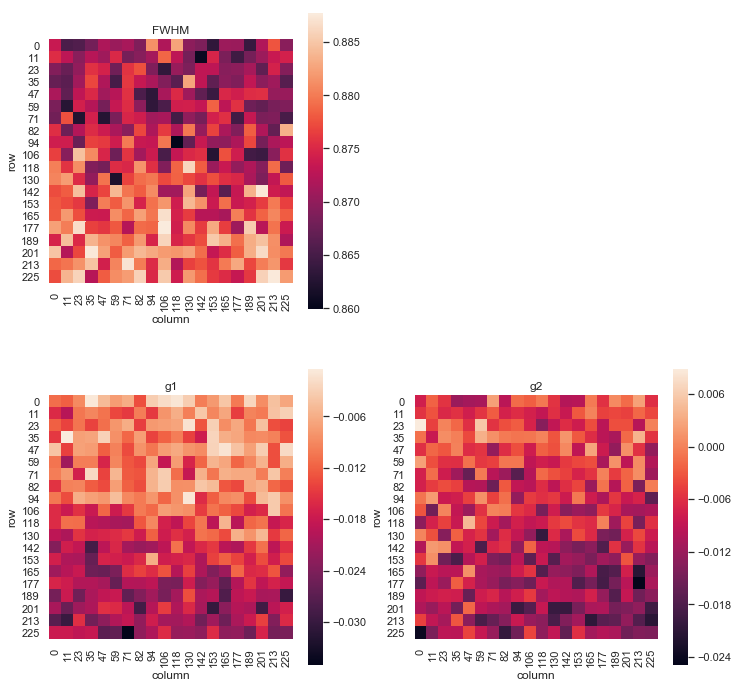

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

labels = ["%d" % s for s in np.linspace(0, 225, 20)]
kwargs = {'xticklabels': labels, 'yticklabels': labels}
sns.heatmap(fwhms, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

axs[0, 1].axis("off")

sns.heatmap(g1, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')

In [41]:
fwhms, g1, g2 = _measure_atm(atm, 0.0, 90)

100%|██████████| 20/20 [01:08<00:00,  3.41s/it]


Text(0.5, 1.0, 'g2')

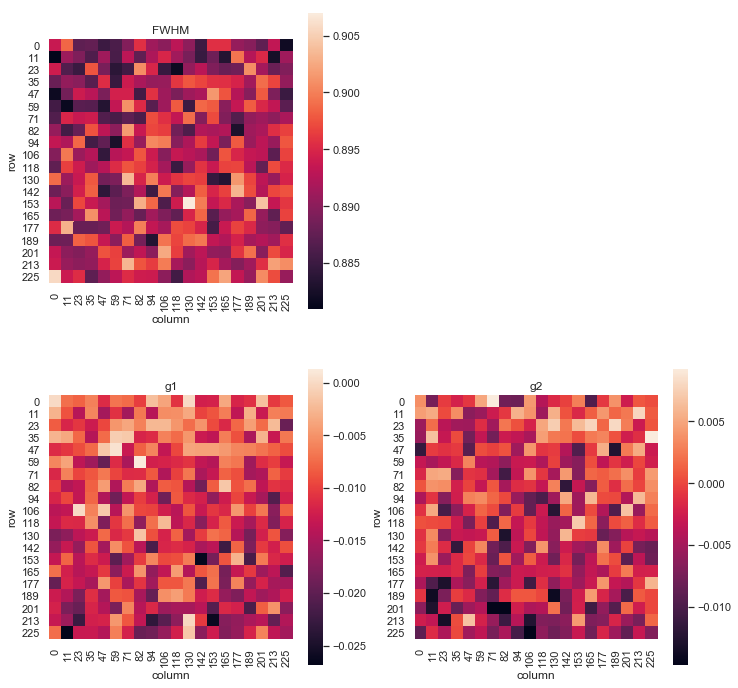

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

labels = ["%d" % s for s in np.linspace(0, 225, 20)]
kwargs = {'xticklabels': labels, 'yticklabels': labels}
sns.heatmap(fwhms, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

axs[0, 1].axis("off")

sns.heatmap(g1, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')

In [ ]:
psf_im = _makePSF(0, 0, 0.25, atm, 0, 1).drawImage(
    nx=33, ny=33, scale=0.25, method='phot', n_photons=1e6)
res = _get_fwhm_g1g2(psf_im)
print(res)
plt.figure()
sns.heatmap(psf_im.array, square=True)

In [ ]:
psf_im = _makePSF(0, 0, 0.25, atm, 0, 90).drawImage(
    nx=33, ny=33, scale=0.25, method='phot', n_photons=1e6)
print(res)
plt.figure()
sns.heatmap(psf_im.array, square=True)

In [ ]:
psf_im = _makePSF(0, 0, 0.25, atm, 0, 1).drawImage(
    nx=33, ny=33, scale=0.25, method='phot', n_photons=5e6)
psf_im1 = _makePSF(0, 10, 0.25, atm, 0, 1).drawImage(
    nx=33, ny=33, scale=0.25, method='phot', n_photons=5e6)


plt.figure()
sns.heatmap((psf_im1.array - psf_im.array)/np.max(psf_im.array), square=True)

In [ ]:
plt.figure()
plt.plot(psf_im.array[:, 16], drawstyle='steps-mid')
plt.plot(psf_im1.array[:, 16], drawstyle='steps-mid')
plt.plot(psf_im1.array[:, 16] - psf_im.array[:, 16], drawstyle='steps-mid')

plt.figure()
plt.plot(psf_im.array[16, :], drawstyle='steps-mid')
plt.plot(psf_im1.array[16, :], drawstyle='steps-mid')
plt.plot(psf_im1.array[16, :] - psf_im.array[16, :], drawstyle='steps-mid')

In [23]:
lam_over_diam = 0.036
obscuration = 0.2
rms_aberration = 0.26
image_size = 17
pixel_scale = 0.25

use_aber = ["defocus", "astig1", "astig2", "coma1", "coma2", "trefoil1", "trefoil2", "spher"]
n_aber = len(use_aber)
aber_weights = np.array((0.13, 0.13, 0.14, 0.06, 0.06, 0.05, 0.06, 0.03))

aber_dict = {}
tmp_vec = np.zeros(n_aber)
for ind_ab in range(n_aber):
    tmp_vec[ind_ab] = rms_aberration * aber_weights[ind_ab] *\
                      rng.normal() / np.sqrt(np.sum(aber_weights**2))
    aber_dict[use_aber[ind_ab]] = tmp_vec[ind_ab]

pad_factor = 1.5
twoR = 2. * lam_over_diam / (
    0.005 * 0.5 * np.pi * np.pi * (1.-obscuration) )
image_size_arcsec = image_size * pixel_scale
if image_size_arcsec < twoR * pad_factor:
    pad_factor = image_size_arcsec / twoR

optpsf = galsim.OpticalPSF(lam_over_diam,
                        obscuration=obscuration,
                        pad_factor=pad_factor*5.0,
                        suppress_warning=False,
                        **aber_dict)

In [24]:
optpsf_im = optpsf.drawImage(nx=17, ny=17, scale=0.25)

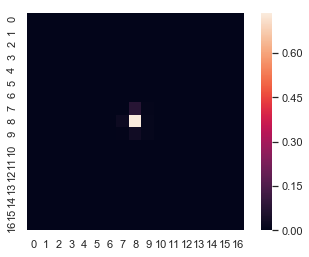

In [27]:
plt.figure()
sns.heatmap(np.arcsinh(optpsf_im.array), square=True)

In [28]:
optpsf_im.calculateFWHM()

0.360987439154921

In [34]:
np.sqrt(np.sum(np.array([ 0.13, 0.13, 0.14, 0.06, 0.06, 0.05, 0.06, 0.03 ])**2))

0.26

In [35]:
pad_factor

1.1651616306841606